In [2]:
import torch
from torch import nn
from collections import OrderedDict
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [37]:
class CoDA_Regress(nn.Module):
    
    def __init__(self, input_dim, dimension, encoder_shape, decoder_shape):
        super(CoDA_Regress, self).__init__()
        
        #define regression layer
        self.linear = nn.Linear(dimension, 1)
        
        encoder_dict = OrderedDict()
        
        #first layer will be twice input size, since we are feeding in both c_kl and X 
        encoder_dict["layer0"] = nn.Linear(2 * input_dim, encoder_shape[0])

        for i in range(0,len(encoder_shape)-1):
            encoder_dict["layer"  + str(i)] = nn.Linear(encoder_shape[i], encoder_shape[i+1])
            encoder_dict["layer_ac"  + str(i)] = nn.ELU()
        encoder_dict["final_layer"] = nn.Linear(encoder_shape[-1], dimension)
        encoder_dict["final_ac"] = nn.ELU()

        self.encoder = nn.Sequential(encoder_dict)
        
        decoder_dict = OrderedDict()
        decoder_dict["layer0"] = nn.Linear(dimension, decoder_shape[0])

        for i in range(0,len(decoder_shape)-1):
            decoder_dict["layer"  + str(i)] = nn.Linear(decoder_shape[i], decoder_shape[i+1])
            decoder_dict["layer_ac"  + str(i)] = nn.ELU()

        #final layer will map back to input dim
        decoder_dict["final_layer"] = nn.Linear(decoder_shape[-1], input_dim)
        decoder_dict["final_ac"] = nn.ELU()

        self.decoder = nn.Sequential(decoder_dict)
        
        
    def forward(self,x):
        EPS = 1e-6   # to avoid log(0)

        #run the encoding and store the low level representation as A
        x_ckl = torch.log(torch.clamp(check(x), EPS, 1))
        
        #pass in both x and x_ckl as per paper
        A = self.encoder(torch.cat((x, x_ckl), 1))
        reconstruction = self.decoder(A)
        pred = self.linear(A)
        #return both the predicted target, and the reconstruction so both can be inputs to the combined loss
        return pred, reconstruction, A
    
    
    def fit(self, X, y, lam, lr):
        
        loss_function = Combined_Loss(lam)
        optim = torch.optim.SGD(model.parameters(), lr = lr)
    
        for epoch in range(0,10000):
            pred, recon, A = self.forward(torch.FloatTensor(X))
            loss = loss_function(recon, torch.FloatTensor(X), pred, torch.FloatTensor(y))
        
            optim.zero_grad()
        
            loss.backward()
            optim.step()
        
            epoch += 1
    
            if (epoch % 1000 == 0):
                print("epoch {}, loss {}".format(epoch, loss))
        
        return 
    
    def transform(self, X):
        pred, recon, A = self.forward(X)
        return A
    
    def predict(self, X):
        pred, recon, A = self.forward(X)
        return pred
    
    #recon remains in CLR space, since the loss is derived for similarity to x_ckl
    def project(self, X):
        pred, recon, A = self.forward(X)
        return recon
        
        
        

In [38]:
class Combined_Loss(torch.nn.Module):
    def __init__(self, lam):
        super(Combined_Loss,self).__init__()
        self.CoDA_Loss = CoDA_Loss()
        self.MSE = nn.MSELoss()
        self.lam = lam
        
    def forward(self,Y,X,y_hat,y):
        #X is original data, Y is CoDA reconstruction, y is targets, y_hat 
        #input needs to be normalised by g(x) (geometric mean) for X_hat
        #TODO centering matrix? Reduce mean? Mask for near zero values?  
        
        #extract reconstruction and original data from concatenation
        
        return  self.MSE(y_hat, y) + self.lam * self.CoDA_Loss(Y,X)  

class CoDA_Loss(torch.nn.Module):
    
    def __init__(self):
        super(CoDA_Loss,self).__init__()
        
    def forward(self,Y,X):
        #X is original data, Y is CoDA reconstruction
        X_check = check(X)
        coda_loss =  torch.sum(torch.exp(torch.clamp(Y, -30, 30))) - torch.sum(X_check * Y)
        return coda_loss

def check(X):
    #assume input is tensor so we can use the numpy() method
    assert type(X) == torch.Tensor
    gmean = torch.prod(X, 1) ** (1./X.shape[1])
    return torch.div(X.t(), torch.clamp(gmean, min=1e-8)).t()

In [5]:
data = pd.read_csv("Data 18. Compositions and total pebble counts of 92 glacial tills.csv")




# headers = data[1]
# features = data[0][:,co_feature_indices]
# targets = data[0][:,target_index]
    
# #normalise the compositional features. TODO anything extra to deal with non compositional features?


features = data[data.columns[1:-1]]
targets = data[data.columns[-1]]

features = np.array([feat/sum(feat) for feat in features.values])


features = torch.FloatTensor(features)
targets = torch.FloatTensor(targets)

targets

tensor([ 282.,  368.,  607.,  532.,  360.,  470.,  102.,  544.,  387.,  294.,
         503.,  697.,  393.,  665.,  347.,  791.,  225.,  175.,  333.,  269.,
         118.,  154.,  276.,  480.,  373.,  369.,  126.,  460.,  441.,  502.,
         126.,  376.,  118.,  303.,  250.,  582.,   69.,  226.,  359.,  453.,
         427.,  334.,  364.,  869.,  441.,  615.,  532.,  417.,  360.,  580.,
         147.,  500.,  943.,  305., 1151.,  457.,  637.,  284.,  386.,  221.,
         208.,  573.,  565.,  170.,  261., 1097.,  408.,   24.,  890.,  168.,
          22.,  601.,  364.,  342.,  867.,  691.,  462.,  318.,  461.,  777.,
         397.,  347.,  744.,  576.,  321.,  382.,  645.,  459.,  681.,  245.,
         575.,  698.])

In [5]:
data = pd.read_csv("Data 5. Sand, silt, clay compositions of 39 sediment samples at different water depths in an Arctic lake.csv")

features = data[data.columns[1:-1]]
targets = data[data.columns[-1]]

features = np.array([feat/sum(feat) for feat in features.values])


features = torch.FloatTensor(features)
targets = torch.FloatTensor(targets)

features

tensor([[0.7750, 0.1950, 0.0300],
        [0.7190, 0.2490, 0.0320],
        [0.5070, 0.3610, 0.1320],
        [0.5236, 0.4102, 0.0662],
        [0.7000, 0.2650, 0.0350],
        [0.6650, 0.3220, 0.0130],
        [0.4310, 0.5530, 0.0160],
        [0.5340, 0.3680, 0.0980],
        [0.1550, 0.5440, 0.3010],
        [0.3170, 0.4150, 0.2680],
        [0.6570, 0.2780, 0.0650],
        [0.7040, 0.2900, 0.0060],
        [0.1740, 0.5360, 0.2900],
        [0.1060, 0.6980, 0.1960],
        [0.3820, 0.4310, 0.1870],
        [0.1080, 0.5270, 0.3650],
        [0.1840, 0.5070, 0.3090],
        [0.0460, 0.4740, 0.4800],
        [0.1560, 0.5040, 0.3400],
        [0.3190, 0.4510, 0.2300],
        [0.0950, 0.5350, 0.3700],
        [0.1710, 0.4800, 0.3490],
        [0.1050, 0.5540, 0.3410],
        [0.0478, 0.5443, 0.4080],
        [0.0260, 0.4520, 0.5220],
        [0.1140, 0.5270, 0.3590],
        [0.0670, 0.4690, 0.4640],
        [0.0690, 0.4970, 0.4340],
        [0.0400, 0.4490, 0.5110],
        [0.074

In [39]:
#training code stub, read in data as X and targets as y
#TODO substitute this into model class, and set up API similar to original CoDA-PCA paper

X = features
y = targets.reshape(-1,1)
model = CoDA_Regress(X.shape[1], 2, [100,], [3,])
#define the combined loss with hyperparameter lambda
# l = 1
# loss_function = Combined_Loss(l)
# optim = torch.optim.SGD(model.parameters(), lr = 1e-4)
    
# for epoch in range(0,10000):
#     pred, recon = model.forward(torch.FloatTensor(X))
#     loss = loss_function(recon, torch.FloatTensor(X), pred, torch.FloatTensor(y))
        
#     optim.zero_grad()
        
#     loss.backward()
#     optim.step()
        
#     epoch += 1
    
#     if (epoch % 1000 == 0):
#         print("epoch {}, loss {}".format(epoch, loss))

model.fit(torch.FloatTensor(X),  torch.FloatTensor(y), 1, lr=1e-4)

epoch 1000, loss 268.6265869140625
epoch 2000, loss 265.5070495605469
epoch 3000, loss 263.0506896972656
epoch 4000, loss 260.69171142578125
epoch 5000, loss 258.3607177734375
epoch 6000, loss 256.0971984863281
epoch 7000, loss 254.01206970214844
epoch 8000, loss 252.25941467285156
epoch 9000, loss 250.92210388183594
epoch 10000, loss 250.00721740722656


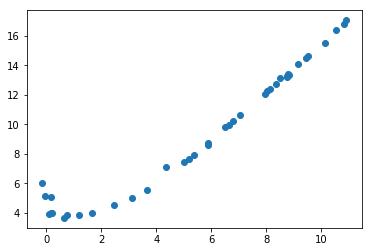

In [40]:
test = model.transform(X).detach().numpy()
plt.scatter(test[:,0], test[:,1])

[epoch     0] L=  3.2262


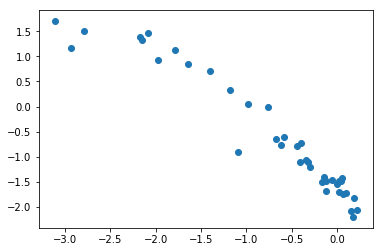

In [33]:
data = pd.read_csv("Data 5. Sand, silt, clay compositions of 39 sediment samples at different water depths in an Arctic lake.csv")

features = data[data.columns[1:-1]]
targets = data[data.columns[-1]]

features = np.array([feat/sum(feat) for feat in features.values])


features = torch.FloatTensor(features)
targets = torch.FloatTensor(targets)

import CodaPCA
pca = CodaPCA.CodaPCA(2,lrate=1e-3,nn_shape=[50,50], alg=CodaPCA.Alg.CODAPCA)

test = pca.fit_transform(features)

plt.scatter(test[:,0], test[:,1])